# Chat with vision models

**If you're looking or the web application, check the src/ folder.**

This notebook is just provided for manual experimentation with the vision model.

## Authenticate to OpenAI

The following code connects to OpenAI, either using an Azure OpenAI account, GitHub models, or local Ollama model. See the README for instruction on configuring the `.env` file.

In [23]:
import os

import azure.identity
import openai
from dotenv import load_dotenv

load_dotenv(".env", override=True)

openai_host = os.getenv("OPENAI_HOST")
if openai_host == "local":
    # Use a local endpoint like llamafile server
    print("Using local OpenAI-compatible API with no key")
    openai_client = openai.OpenAI(api_key="no-key-required", base_url=os.getenv("LOCAL_OPENAI_ENDPOINT"))
elif openai_host == "github":
    print("Using GitHub-hosted model")
    openai_client = openai.OpenAI(
        api_key=os.environ["GITHUB_TOKEN"],
        base_url=os.environ["GITHUB_MODELS_ENDPOINT"],
    )
elif os.getenv("AZURE_OPENAI_KEY"):
    # Authenticate using an Azure OpenAI API key
    # This is generally discouraged, but is provided for developers
    # that want to develop locally inside the Docker container.
    print("Using Azure OpenAI with key")
    openai_client = openai.AzureOpenAI(
        api_version=os.getenv("AZURE_OPENAI_API_VERSION") or "2024-02-15-preview",
        azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        api_key=os.getenv("AZURE_OPENAI_KEY"),
    )
elif os.getenv("AZURE_OPENAI_ENDPOINT"):
    # Authenticate using the default Azure credential chain
    # See https://docs.microsoft.com/azure/developer/python/azure-sdk-authenticate#defaultazurecredential
    # This will *not* work inside a local Docker container.
    # If using managed user-assigned identity, make sure that AZURE_CLIENT_ID is set
    # to the client ID of the user-assigned identity.
    print("Using Azure OpenAI with default credential")
    default_credential = azure.identity.DefaultAzureCredential(exclude_shared_token_cache_credential=True)
    token_provider = azure.identity.get_bearer_token_provider(
        default_credential, "https://cognitiveservices.azure.com/.default"
    )
    openai_client = openai.AzureOpenAI(
        api_version=os.getenv("AZURE_OPENAI_API_VERSION") or "2024-02-15-preview",
        azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        azure_ad_token_provider=token_provider,
    )

Using Azure OpenAI with default credential


## Send an image by URL

In [24]:
messages = [
    {"role": "user",
        "content": [
            {"text": "Is this a unicorn?", "type": "text"},
            {"image_url": {"url": "https://upload.wikimedia.org/wikipedia/commons/6/6e/Ur-painting.jpg"}, "type": "image_url"},
        ]
    }
]
response = openai_client.chat.completions.create(
    model=os.environ["OPENAI_MODEL"],
    messages=messages,
    temperature=0.5
)

print(response.choices[0].message.content)

No, this is not a unicorn. The image depicts a bovine animal, likely a type of cattle, with two horns. Unicorns are mythical creatures typically depicted as horses with a single horn on their forehead.


## Send an image by Data URI



''
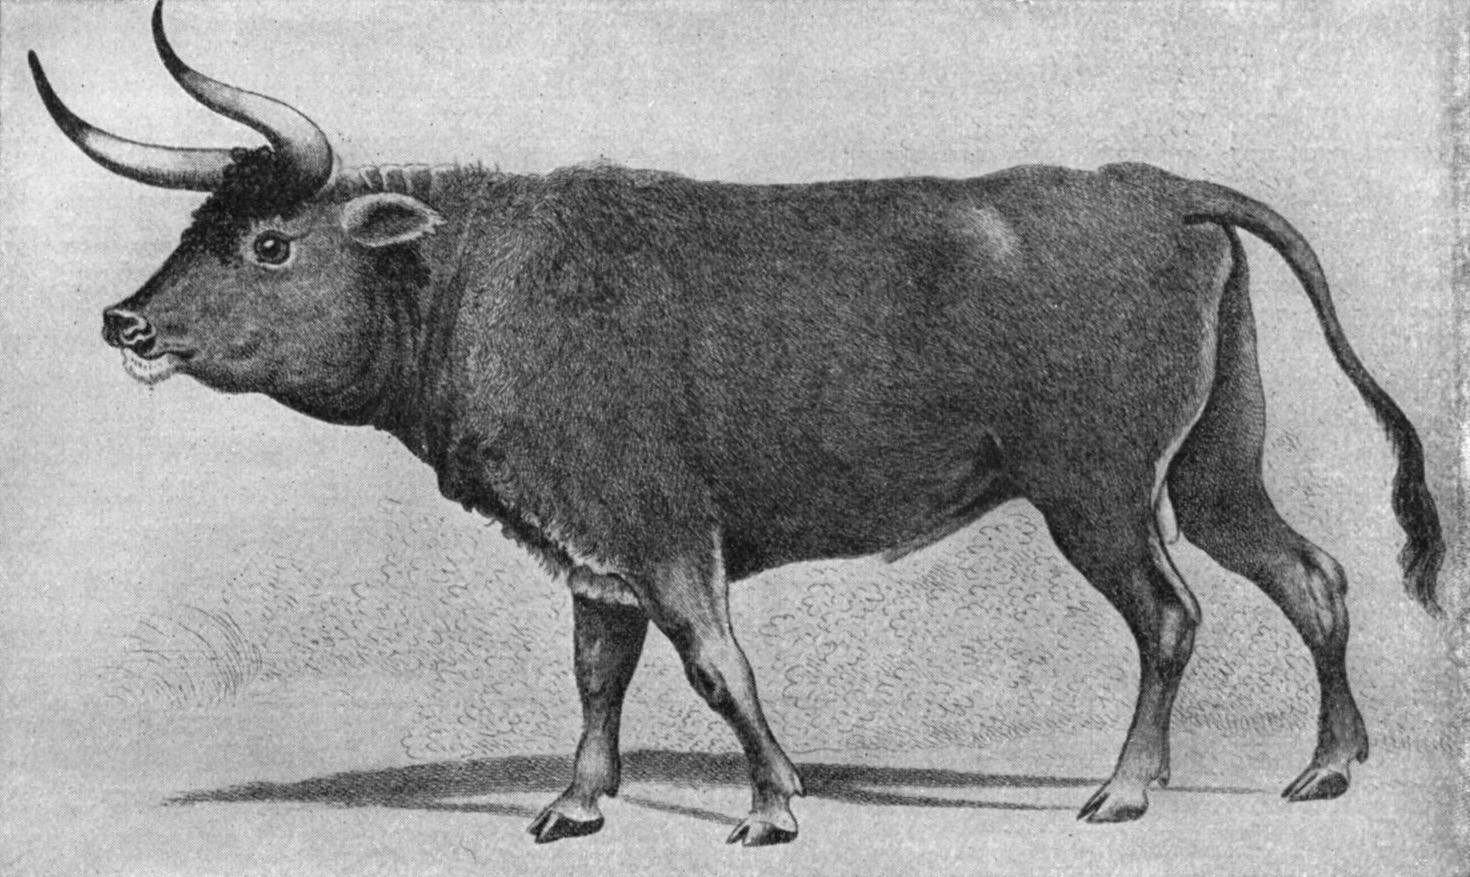

In [25]:
import base64

def open_image_as_base64(filename):
    with open(filename, "rb") as image_file:
        image_data = image_file.read()
    image_base64 = base64.b64encode(image_data).decode("utf-8")
    return f"data:image/png;base64,{image_base64}"

open_image_as_base64("ur.jpg")

In [26]:
response = openai_client.chat.completions.create(
    model=os.environ["OPENAI_MODEL"],
    messages=[
        {"role": "user",
            "content": [
                {"text": "how could I make this into a unicorn though??", "type": "text"},
                {"image_url": {"url": open_image_as_base64("ur.jpg")}, "type": "image_url"},
            ]
        }
    ]
)

print(response.choices[0].message.content)

Transforming this image of a bull into a unicorn would involve some creative digital editing. Here's a process you could follow:

### Step 1: Preparation
1. **Choose a Software**: Use a digital illustration or image editing program like Adobe Photoshop, GIMP, or Procreate.

### Step 2: Drawing the Horn
1. **Remove Existing Horns**: Use the software’s clone stamp tool or healing tool to remove the bull’s horns.
2. **Add Unicorn Horn**: Draw a single spiraled horn on the bull’s forehead. Use reference images of unicorn horns to get the proportions and details right. Make sure the horn is centered between the bull’s eyes and aligned correctly.

### Step 3: Adding Details
1. **Add Magical Elements**: Consider adding sparkles, a glowing mane, or a magical aura around the unicorn.
2. **Enrich the Coat**: Paint the bull’s coat in a white or pastel color, typical of unicorn depictions. You might want to add some iridescent or glitter effects.

### Step 4: Refining the Image
1. **Smooth Transit

## Use cases for image analysis

### Insurance claim processing

In [27]:
response = openai_client.chat.completions.create(
    model=os.environ["OPENAI_MODEL"],
    messages=[
        {"role": "system", "content": "You are an AI assistant that helps auto insurance companies process claims. You accept images of damaged cars that are submitted with claims, and you are able to make judgments about the causes of automobile damage, and the validity of claims regarding that damage."},
        {"role": "user",
            "content": [
                {"text": "Claim states that this damage is due to hail. Is it valid?", "type": "text"},
                {"image_url": {"url": open_image_as_base64("dented_car.jpg")}, "type": "image_url"},
            ]
        }
    ]
)

print(response.choices[0].message.content)

The damage shown in the image is not consistent with typical hail damage. Hail damage usually appears as small dents or dings on the surface of a vehicle, often without causing significant deformation. The damage seen here, particularly the large dent and severe deformation of the hood, suggests an impact with a larger object, such as another vehicle or a stationary object.

Therefore, the claim stating that the damage is due to hail does not appear to be valid based on the image provided.


### Appliance help

In [28]:
response = openai_client.chat.completions.create(
    model=os.environ["OPENAI_MODEL"],
    messages=[
        {"role": "user",
            "content": [
                {"text": "How do I set this to wash the dishes quickly?", "type": "text"},
                {"image_url": {"url": open_image_as_base64("dishwasher.png")}, "type": "image_url"},
            ]
        }
    ]
)

print(response.choices[0].message.content)

To wash the dishes quickly, you can use the "Quick 45°" setting on your dishwasher. Here are the steps to set it:

1. Press the "On/Off" button to turn the dishwasher on.
2. Press the button labeled "Quick 45°."
3. Press the "Start" button.

This should start your dishwasher on the quick wash cycle, allowing your dishes to be cleaned in a shorter amount of time.


### Assistance for vision-impaired

In [29]:
response = openai_client.chat.completions.create(
    model=os.environ["OPENAI_MODEL"],
    messages=[
        {"role": "user",
            "content": [
                {"text": "is there anything good for vegans on this menu?", "type": "text"},
                {"image_url": {"url": open_image_as_base64("menu.png")}, "type": "image_url"},
            ]
        }
    ]
)

print(response.choices[0].message.content)

There are a few options that can be good for vegans on this menu, though some might require slight modifications:

### Antipasti
- **Bruschetta Trio (only the Cherry tomato, caper, garlic confitura, and basil option)**: This selection is vegan if you avoid the other options with goat cheese and creme fraiche, or check if those can be substituted or omitted.

- **Spinaci Soffritti**: Fresh spinach sautéed with lemon and garlic is vegan. 

### Zuppe & Insalate
- **Panzanella con Fagioli**: Vine tomatoes and bread salad with sliced onions, basil, marinated Cannellini beans, cucumbers, and avocado. Ensure no non-vegan ingredients are in the vinaigrette.

- **Insalata Di Mista**: Seasonal greens tossed with Carmine’s house vinaigrette. Check if the vinaigrette is vegan or request a vinegar and oil dressing instead. Avoid adding grilled chicken or steak.

### Pasta & Risotto
- **Spaghetti Ortolano**: Arugula, goat cheese, tomatoes, pine nuts, and extra virgin olive oil. To make it vegan, ask

## Automated image captioning

In [30]:
response = openai_client.chat.completions.create(
    model=os.environ["OPENAI_MODEL"],
    messages=[
        {"role": "user",
            "content": [
                {"text": "Suggest an alt text for this image", "type": "text"},
                {"image_url": {"url": open_image_as_base64("azure_arch.png")}, "type": "image_url"},
            ]
        }
    ]
)

print(response.choices[0].message.content)

Diagram showing the architecture of a containerized chat application deployment using Azure services. The main components are:

- Container Apps Environment (chat-app-cnbr6e7fwgzj2-con) at the top center.
- Azure AI services (cnbr6e7fwgzj2-cog) at the top right.
- Managed Identity (chat-app-cnbr6e7fwgzj2-id-aca) on the left.
- Container App (chat-app-cnbr6e7fwg-ca) in the center connected to both the Container Apps Environment and Managed Identity.
- Log Analytics Workspace (chat-app-cnbr6e7fwgzj2-log) at the bottom left.
- Container Registry (chatappcnbr6e7fwgzj2registry) at the bottom center.
- Key Vault (chatappcnbr6e7f-vault) at the bottom right.


### Table analysis

In [32]:
response = openai_client.chat.completions.create(
    model=os.environ["OPENAI_MODEL"],
    messages=[
        {"role": "user",
            "content": [
                {"text": "What's the cheapest plant?", "type": "text"},
                {"image_url": {"url": open_image_as_base64("page_0.png")}, "type": "image_url"},
            ]
        }
    ]
)

print(response.choices[0].message.content)

The cheapest plant available is the Thinngrass (Agrostis pallens) at $0.58.
